In [6]:
from torch.utils.data import Dataset
from fl_puf.Utils.tabular_data_loader import get_tabular_numpy_dataset
import torch.nn as nn
import numpy as np
import torch 
from torch import nn

In [7]:
class TabularDataset(Dataset):
    def __init__(self, x, z, y):
        """
        Initialize the custom dataset with x (features), z (sensitive values), and y (targets).

        Args:
        x (list of tensors): List of input feature tensors.
        z (list): List of sensitive values.
        y (list): List of target values.
        """
        self.samples = x
        self.sensitive_features = z
        self.sensitive_attribute = z
        self.gender = z
        self.classes = y
        self.targets = y

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Get a single data point from the dataset.

        Args:
        idx (int): Index to retrieve the data point.

        Returns:
        sample (dict): A dictionary containing 'x', 'z', and 'y'.
        """
        x_sample = self.samples[idx]
        z_sample = self.sensitive_features[idx]
        y_sample = self.targets[idx]

        return x_sample, z_sample, y_sample


class LinearClassificationNet(nn.Module):
    """
    A fully-connected single-layer linear NN for classification.
    """

    def __init__(self, input_size=11, output_size=2):
        super(LinearClassificationNet, self).__init__()
        self.layer1 = nn.Linear(input_size, output_size, bias=False)

    def forward(self, x):
        x = self.layer1(x.float())
        return x


In [33]:
X, z, y = get_tabular_numpy_dataset(
        dataset_name="adult",
        num_sensitive_features=1,
        dataset_path="./data/Tabular/adult/",
    )
print(X.shape)

Using ['sex_binary'] as sensitive feature(s).
(48842, 110)


In [37]:
# Create a pandas dataframe for the dataset using X and y as target
df_ = pd.DataFrame(X)
df_['target'] = y
df_.head()

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,target
0,0.301370,0.044131,0.800000,0.02174,0.0,0.397959,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.452055,0.048052,0.800000,0.00000,0.0,0.122449,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.287671,0.137581,0.533333,0.00000,0.0,0.397959,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.493151,0.150486,0.400000,0.00000,0.0,0.397959,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.150685,0.220635,0.800000,0.00000,0.0,0.397959,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
sv = [item[0] for item in z]
for column in df_.columns:
    if list(df_[column]) == list(sv):
        print(column)
        break

[0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

In [34]:
# import pandas as pd
# df_ = pd.read_csv("./data/Tabular/adult/adult.data", header=None)

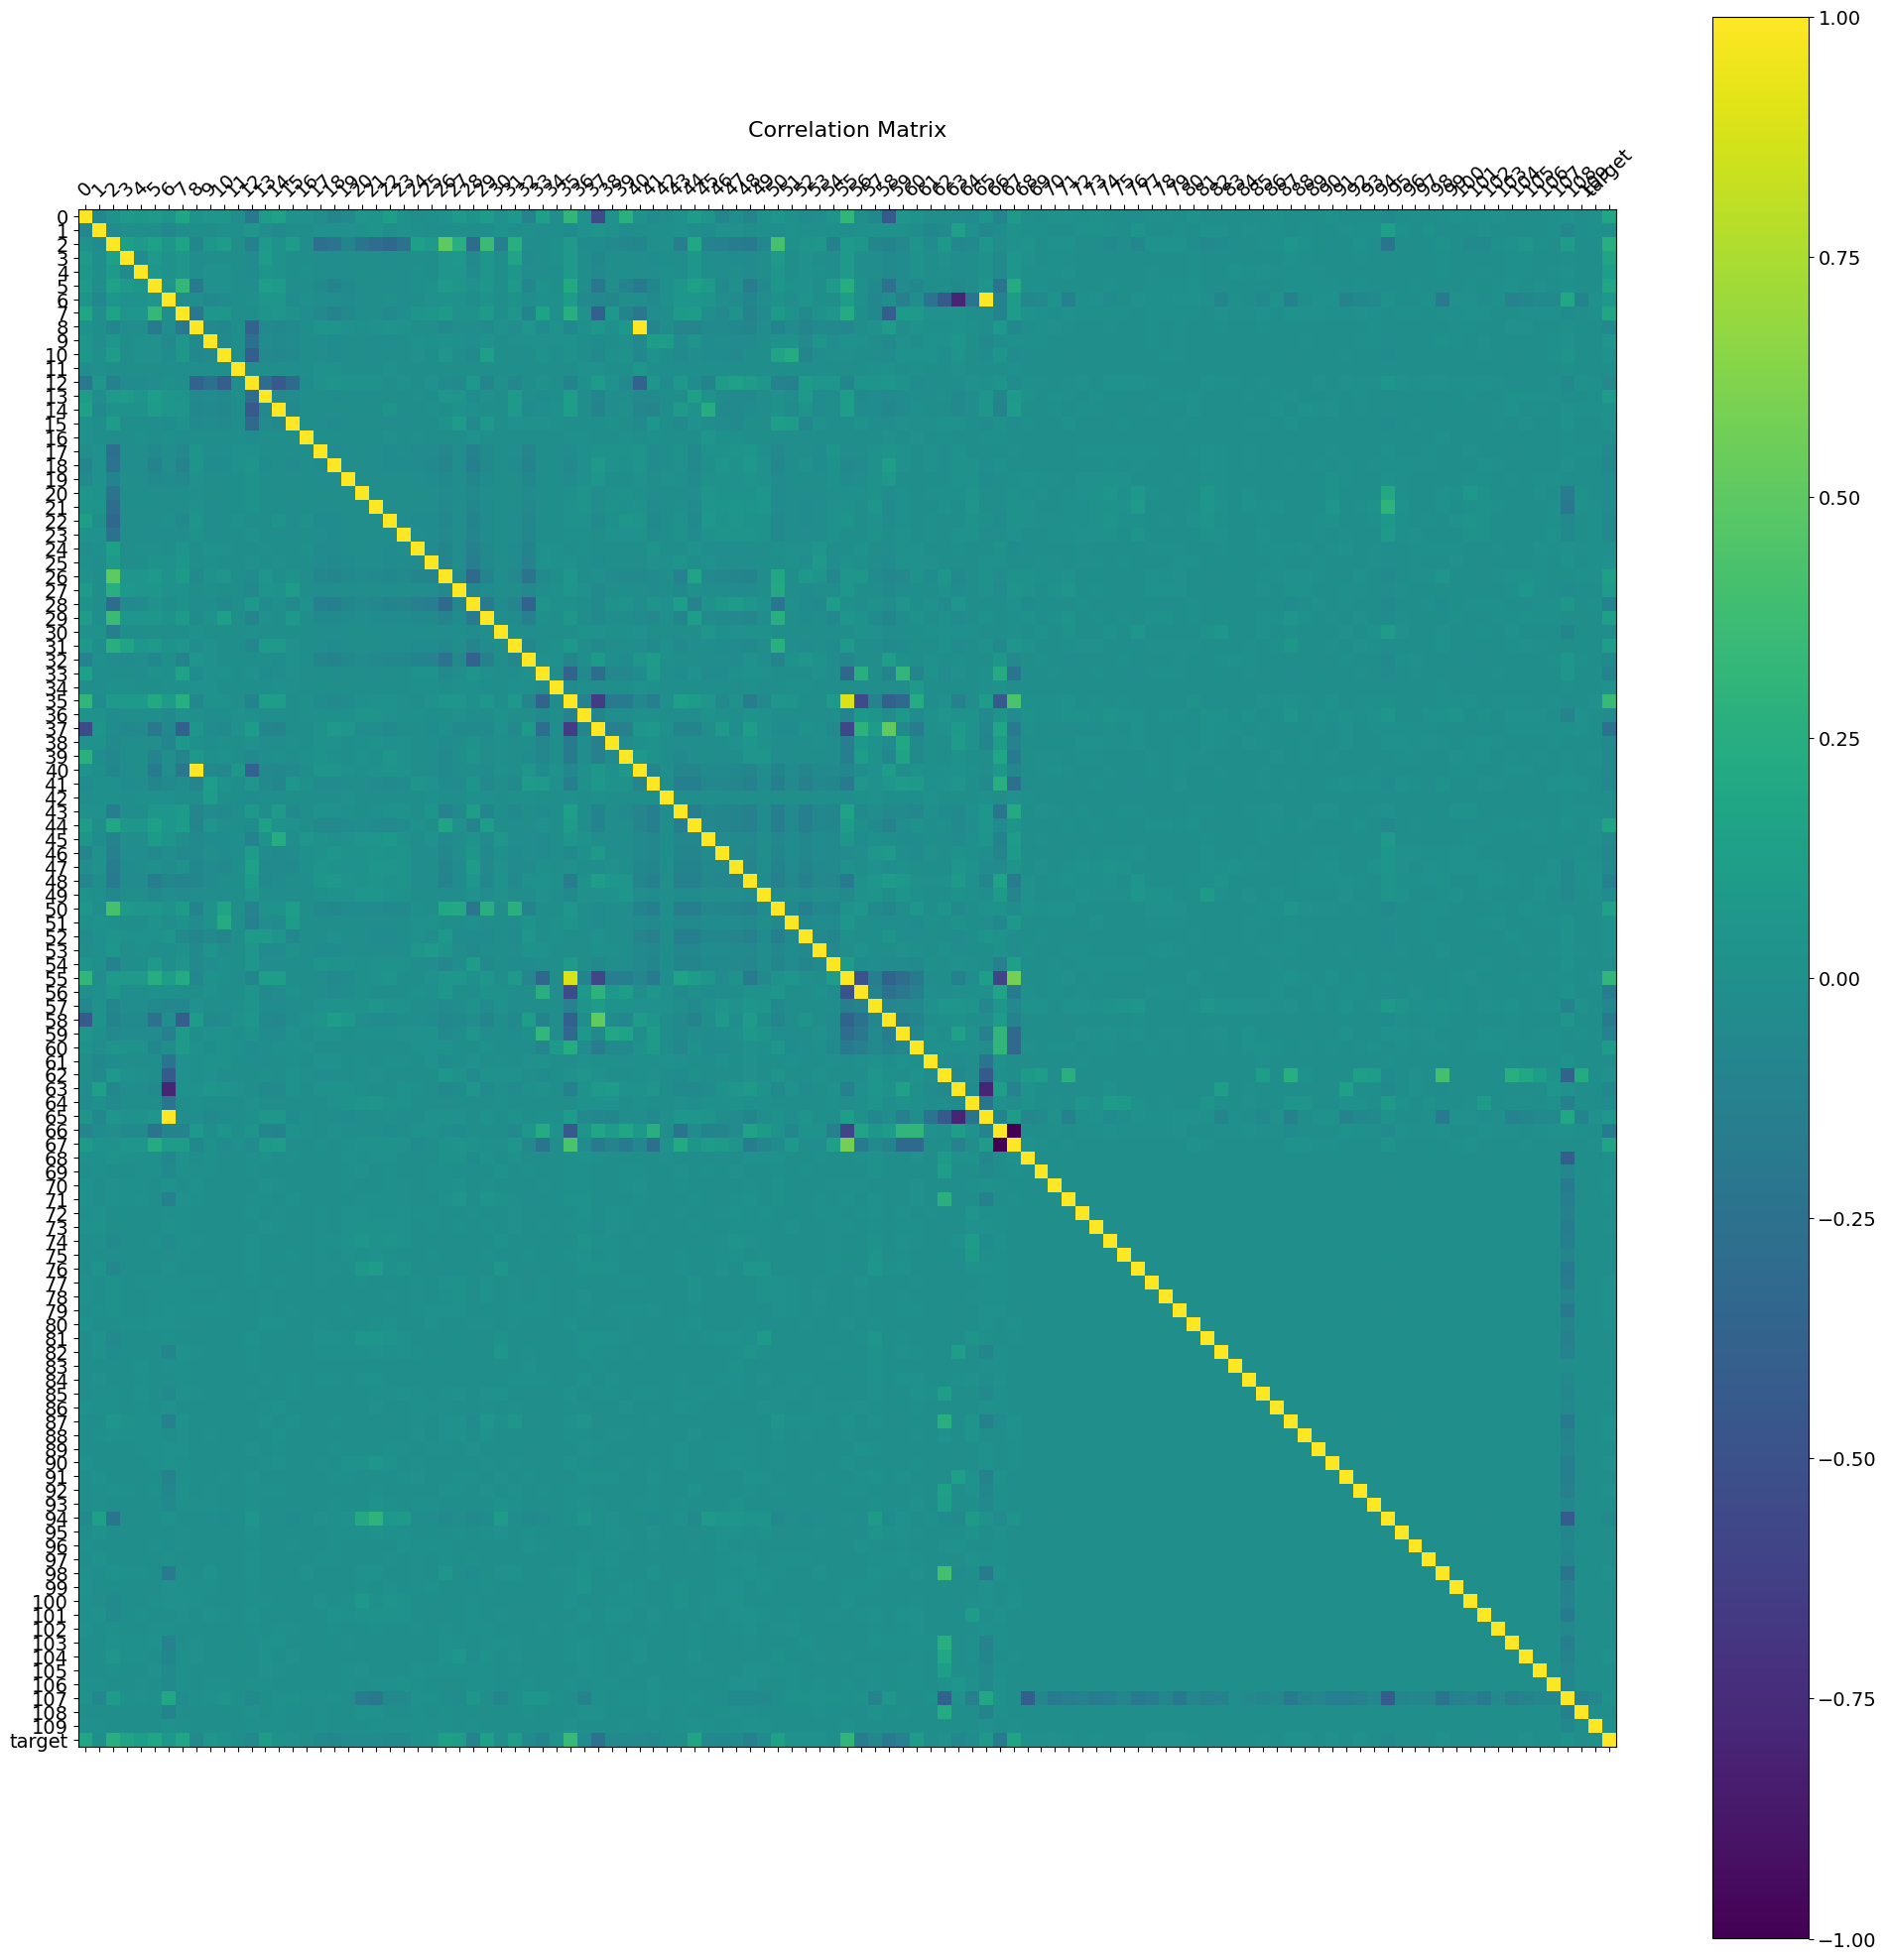

In [56]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(25, 25))
plt.matshow(df_.corr(), fignum=f.number)
plt.xticks(range(df_.select_dtypes(['number']).shape[1]), df_.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_.select_dtypes(['number']).shape[1]), df_.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [57]:
# print without cutting the output 
pd.options.display.max_rows = 999
df_.corr().loc['target']

0         0.178818
1        -0.006871
2         0.260855
3         0.171772
4         0.116651
5         0.178245
6         0.065365
7         0.177662
8        -0.061991
9         0.046651
10        0.025836
11       -0.006258
12       -0.058127
13        0.106617
14        0.021495
15        0.009888
16       -0.009070
17       -0.054016
18       -0.068133
19       -0.035087
20       -0.026460
21       -0.036090
22       -0.045644
23       -0.042634
24        0.002499
25        0.008359
26        0.140379
27        0.107181
28       -0.102429
29        0.130931
30       -0.018043
31        0.124462
32       -0.048167
33       -0.097981
34        0.008230
35        0.346926
36       -0.033078
37       -0.248657
38       -0.057510
39       -0.051004
40       -0.062272
41       -0.068872
42       -0.004482
43       -0.008800
44        0.167342
45       -0.040279
46       -0.068247
47       -0.054434
48       -0.121032
49       -0.030064
50        0.145725
51        0.021125
52        0.

In [4]:
custom_dataset = TabularDataset(
        x=X, z=z, y=y
)

train_loader = torch.utils.data.DataLoader(
    custom_dataset,
    batch_size=32,
)

In [23]:
def accuracy(preds, labels):
    return (preds == labels).mean()

def train(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.CrossEntropyLoss()

    losses = []
    top1_acc = []

    for i, (images, sensitive_value,  target) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        target = target.long()
        target = target.to(device)

        

        # compute output
        output = model(images)
        
        loss = criterion(output, target)

        

        preds = np.argmax(output.detach().cpu().numpy(), axis=1)
        labels = target.detach().cpu().numpy()

        # measure accuracy and record loss
        acc = accuracy(preds, labels)

        losses.append(loss.item())
        top1_acc.append(acc)

        loss.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            print(
                f"\tTrain Epoch: {epoch} \t"
                f"Loss: {np.mean(losses):.6f} "
                f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
            )

In [6]:
model = LinearClassificationNet(input_size=110, output_size=2)

In [24]:
train(model=model, 
        train_loader=train_loader, 
        optimizer=torch.optim.Adam(
                model.parameters(),
                lr=0.01,
            ), 
        epoch=2, 
        device="cpu")

	Train Epoch: 2 	Loss: 0.335527 Acc@1: 84.218750 
	Train Epoch: 2 	Loss: 0.333461 Acc@1: 84.468750 
	Train Epoch: 2 	Loss: 0.331134 Acc@1: 84.552083 
	Train Epoch: 2 	Loss: 0.327464 Acc@1: 84.730469 
	Train Epoch: 2 	Loss: 0.326217 Acc@1: 84.828125 
